# Naive Bayes 

In [ ]:
# import nltk
import nltk 
nltk.download('all') 


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [ ]:
# store data as a panda dataframe 

import pandas as pd 

import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

#import data as a tfds dataset 
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)

#convert to a pandas dataframe and split into train and test 
pd_dataset_train = tfds.as_dataframe(dataset['train'], info)
pd_dataset_test = tfds.as_dataframe(dataset['test'], info)

#length of training data 
pd_dataset_train.value_counts()


label  text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [ ]:
#take a look at the first few rows for training data 
pd_dataset_train.head


<bound method NDFrame.head of        label                                               text
0          0  b"This was an absolutely terrible movie. Don't...
1          0  b'I have been known to fall asleep during film...
2          0  b'Mann photographs the Alberta Rocky Mountains...
3          1  b'This is the kind of film for a snowy Sunday ...
4          1  b'As others have mentioned, all the women that...
...      ...                                                ...
24995      0  b'I have a severe problem with this show, seve...
24996      1  b'The year is 1964. Ernesto "Che" Guevara, hav...
24997      0  b'Okay. So I just got back. Before I start my ...
24998      0  b'When I saw this trailer on TV I was surprise...
24999      1  b'First of all, Riget is wonderful. Good comed...

[25000 rows x 2 columns]>

In [ ]:
#make sure that tweets are stored as type string 
pd_dataset_train['text'] = pd_dataset_train['text'].astype(str)

In [ ]:
pd_dataset_train.info()

<class 'tensorflow_datasets.core.as_dataframe.StyledDataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   25000 non-null  int64 
 1   text    25000 non-null  object
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [ ]:
# develop a custom tokeniser 

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
import string

stop_words = set(stopwords.words('english'))
table = str.maketrans('', '', string.punctuation)
l = WordNetLemmatizer() 

# this tokenizer cleans the data 

def clean(v):
    tokens = word_tokenize(v) #tokenize
    lower_case = [i.lower() for i in tokens] #make letters lowercase
    strip = [i.translate(table) for i in lower_case] # remove punctuations 
    words = [i for i in strip if i.isalpha()] #remove non alphabetic terms
    main_words = [i for i in words if not i in stop_words] #remove stop words
    final_words = [l.lemmatize(i) for i in main_words] # lemmatize the words
    return (final_words)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# convert the reviews into sparse vectors 
vectoriser = CountVectorizer(tokenizer= clean)
Count_train = vectoriser.fit_transform(pd_dataset_train.text)
Count_test = vectoriser.transform(pd_dataset_test.text)

In [ ]:
# collect the training and test labels seperately 
train_label = pd_dataset_train.label
train_text = Count_train

test_label = pd_dataset_test.label
test_text = Count_test

In [ ]:
#25000 test size 
test_label.shape

(25000,)

In [ ]:
#evaluating the multinomial naive bayes model

from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics 

model1 = MultinomialNB()
model1.fit(train_text, train_label)

test = model1.predict(test_text)
accuracy = metrics.accuracy_score(test, test_label)

print("Multinomial Naive Bayes test accuaracy: ", accuracy)


Multinomial Naive Bayes test accuaracy:  0.8226


# LSTM

In [ ]:
#import the required libraries 

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.data import AUTOTUNE
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import numpy as np


In [ ]:
#load data as a tensorflow dataset 
data = tfds.load('imdb_reviews',
                  as_supervised=True)


In [ ]:
#create validation dataset
train_data = data['train']
val_data = data["test"].take(10000) 
test_data = data["test"].skip(10000)

In [ ]:
#divide into train and test 
#shuffle both data sets 
#batch the datasets 
#prefetch data to improve latency 

train_data = train_data.shuffle(25000).batch(30).prefetch(AUTOTUNE)
val_data = val_data.shuffle(25000).batch(30).prefetch(AUTOTUNE)
test_data = test_data.shuffle(25000).batch(30).prefetch(AUTOTUNE)

In [ ]:
#tokenize the raw text using a text vectorization
# preprocessing removes punctuation, makes letters lowercase,
#constrains output length to 400, creates a vocabulary of 
#upto 3000 unique words
#outputs integer word indices

vector_layer = TextVectorization(standardize = "lower_and_strip_punctuation",
                                 max_tokens= 3000,
                                 pad_to_max_tokens=True,
                                 output_mode = "int",
                                 output_sequence_length = 400   
                                 )

#create vocaulary based on training data text
vector_layer.adapt(train_data.map(lambda x, y: x ))

#preprocess the data using text vectorization 
train_data = train_data.map(lambda x, y: (vector_layer(x), y))
test_data = test_data.map(lambda x, y : (vector_layer(x), y))
val_data = val_data.map(lambda x, y : (vector_layer(x), y))

In [ ]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense

# specify model architecture 
lstm_model = tf.keras.Sequential()

#turn indices into dense vectors
#takes preprocessed dataset as input
lstm_model.add(Embedding(
                input_dim= 3000, #size of vocab 
                output_dim=128,
                mask_zero=True,
                input_length = 400, #output of vector layer
                name = "Embeding"))

#first LSTM layer
lstm_model.add(Bidirectional(LSTM(128,
                                  dropout=0.2,
                                  kernel_regularizer = 'l1_l2', 
                                  return_sequences=True,
                                  name = "LSTM"))) 
#second LSTM layer
lstm_model.add(Bidirectional(LSTM(64,
                                  dropout=0.2,
                                  kernel_regularizer = 'l1_l2',                                              
                                  name = "LSTM"))) 
#dense layer 
lstm_model.add(Dense(128, activation='relu',
                     kernel_regularizer = 'l2',                          
                     name = "Dense"))

#final classification layer with softmax activation
lstm_model.add(Dense(1,activation= "sigmoid",
                     name = "Classifier")) 


In [ ]:
#print model summary
print(lstm_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embeding (Embedding)         (None, 400, 128)          384128    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 400, 256)          263168    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 128)               164352    
_________________________________________________________________
Dense (Dense)                (None, 128)               16512     
_________________________________________________________________
Classifier (Dense)           (None, 1)                 129       
Total params: 828,289
Trainable params: 828,289
Non-trainable params: 0
_________________________________________________________________
None


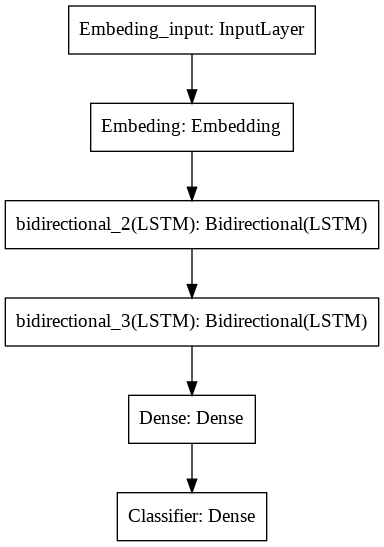

In [ ]:
# LSTM visualisation
from tensorflow.keras.utils import plot_model
plot_model(lstm_model)

In [ ]:
#compile the model 

from tensorflow.keras import optimizers
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy


opt = tf.keras.optimizers.Adam(learning_rate=1e-4)

loss_func = BinaryCrossentropy(from_logits=True)

metric = BinaryAccuracy()

lstm_model.compile(loss= loss_func,
                   optimizer= opt,
                   metrics= metric)

In [ ]:
#fit the model

epoch = 10
steps_per_epoch = 70
batch_size = 250
val_steps = 50

lstm_history = lstm_model.fit(train_data,
                              epochs= epoch,
                              validation_data = val_data,
                              #validation_steps= val_steps,
                              steps_per_epoch = steps_per_epoch,
                              shuffle = True,
                              batch_size = batch_size
                              )

Epoch 1/10
70/70 [==============================] - 154s 2s/step - loss: 79.2707 - binary_accuracy: 0.4907 - val_loss: 71.2653 - val_binary_accuracy: 0.4947
Epoch 2/10
70/70 [==============================] - 135s 2s/step - loss: 68.7477 - binary_accuracy: 0.5343 - val_loss: 61.4418 - val_binary_accuracy: 0.5089
Epoch 3/10
70/70 [==============================] - 141s 2s/step - loss: 59.1492 - binary_accuracy: 0.5596 - val_loss: 52.5028 - val_binary_accuracy: 0.5789
Epoch 4/10
70/70 [==============================] - 138s 2s/step - loss: 50.4212 - binary_accuracy: 0.5983 - val_loss: 44.3966 - val_binary_accuracy: 0.5913
Epoch 5/10
70/70 [==============================] - 134s 2s/step - loss: 42.5122 - binary_accuracy: 0.6120 - val_loss: 37.1129 - val_binary_accuracy: 0.5816
Epoch 6/10
70/70 [==============================] - 135s 2s/step - loss: 35.4353 - binary_accuracy: 0.5656 - val_loss: 30.5784 - val_binary_accuracy: 0.6367
Epoch 7/10
70/70 [==============================] - 135s 2

In [ ]:
#test loss and accuracy
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(test_data)


500/500 [==============================] - 99s 197ms/step - loss: 11.4256 - binary_accuracy: 0.7947


LSTM Test Loss: 11.425619125366211
LSTM Test Accuracy: 0.7946666479110718


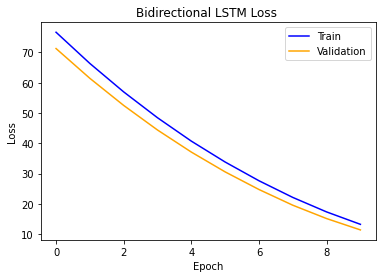

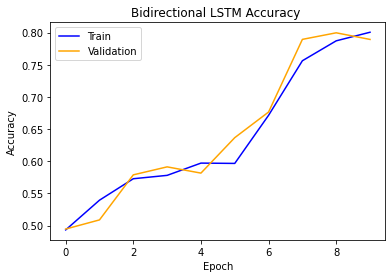

<Figure size 432x288 with 0 Axes>

In [ ]:
from matplotlib import pyplot as plt

print('LSTM Test Loss:', lstm_test_loss)
print('LSTM Test Accuracy:', lstm_test_acc)

#plot loss and accuracy

plt.title('Bidirectional LSTM Loss ')
plt.plot(lstm_history.history['loss'], color='blue', label='train')
plt.plot(lstm_history.history['val_loss'], color='orange', label='validation')
plt.legend(['Train', 'Validation'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
plt.clf()

plt.title('Bidirectional LSTM Accuracy ')
plt.plot(lstm_history.history['binary_accuracy'], color='blue', label='train')
plt.plot(lstm_history.history['val_binary_accuracy'], color='orange', label='validation')
plt.legend(['Train', 'Validation'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()
plt.clf()


# Load and Preprocess Data


In [ ]:
# this data preprocessing is valid for ALBERT, BERT Expert,
# and ELECTRA
!pip install -q tf-models-official
!pip install -q tensorflow-text


In [ ]:
import os
import shutil
import tensorflow_hub as hub
import tensorflow_text 
import tensorflow as tf
  

In [ ]:
#load the data into a directory

file_url = "https://ai.stanford.edu/%7Eamaas/data/sentiment/aclImdb_v1.tar.gz"

review_data = tf.keras.utils.get_file('aclImdb_v1.tar.gz', file_url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

review_dataset = os.path.join(os.path.dirname(review_data), 'aclImdb')

train_dataset = os.path.join(review_dataset, 'train')

remove_data = os.path.join(train_dataset, 'unsup')
shutil.rmtree(remove_data)


In [ ]:
# split into training, testing and validation datasets 
seed = 10

train_data = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    class_names = ["neg", 'pos'],
    )

val_data = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    validation_split=0.4,
    subset='validation',
    class_names = ["neg", 'pos'],
    seed=seed)


test_data = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    class_names = ["neg", 'pos'],
    validation_split=0.4,
    subset='training',
    seed=seed)

#cache and prefetch to improve latency
train_data = train_data.cache().prefetch(tf.data.AUTOTUNE)
val_data = val_data.cache().prefetch(tf.data.AUTOTUNE)
test_data = test_data.cache().prefetch(tf.data.AUTOTUNE)


Found 25000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.
Using 10000 files for validation.
Found 25000 files belonging to 2 classes.
Using 15000 files for training.


In [ ]:
#look at some tweets from the training data 
for x,y in train_data.take(5): 
  print(f"review: {x[1]}")
  print(f"category: {y[1]}")

review: b"well done giving the perspective of the other side fraulein doktor captures both the cost and the futility of war. excellent acting especially when german high command refuses in the name of chivalry to present medal kaiser ordered struck. the scenes of carnage are probably too intense for effete US minds who'd probably prefer some silly speeches and senseless abstractions like 14 points or the league of nations. real americans might appreciate the story line and the action. for all the action and intrigue, fraulein doktor compares favo(u)rably to Jacob's Ladder."
category: 1
review: b'To sat how awful The Shield is, you\'d have to write pages and pages, so suffice it to say that it is a monument to bad directing.<br /><br />"When Directors Go Awry" should have been the title of this production. Indeed, directors are supposed to infuse their work with a sense of visual style and story-telling that propels the story forward.<br /><br />How is constantly shaking the camera and 

In [ ]:
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model

# function to build b bert model 

def bert_model(model_url, preprocessor_url):
  embedings = Input(shape=(), dtype=tf.string) #text input
  vectorization_layer = hub.KerasLayer(preprocessor_url) #preprocessor
  vectorized_tokens = vectorization_layer(embedings) #tokenize and vectorize 
  bert_model = hub.KerasLayer(model_url, trainable=True) #load model
  model_output = bert_model(vectorized_tokens) #apply model to vectorized tweets
  pooled_output = model_output['pooled_output'] #collect pooled output 
  output = Dropout(0.2)(pooled_output) #dropout layer
  output = Dense(64, activation= "relu",
                 kernel_regularizer = "l1_l2")(output) #dense layer
  output = Dropout(0.2)(output) #dropout layer
  output = Dense(1, activation= "sigmoid")(output) #classification layer
  return tf.keras.Model(embedings, output) #return the model 



In [ ]:
#trsting that the function works 

test_model = bert_model("https://tfhub.dev/tensorflow/albert_en_base/3",
                        "http://tfhub.dev/tensorflow/albert_en_preprocess/3")
#print test model summary 
test_model.summary()



Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer_8 (KerasLayer)      {'input_word_ids': ( 0           input_5[0][0]                    
__________________________________________________________________________________________________
keras_layer_9 (KerasLayer)      {'sequence_output':  11683584    keras_layer_8[0][0]              
                                                                 keras_layer_8[0][1]              
                                                                 keras_layer_8[0][2]              
____________________________________________________________________________________________

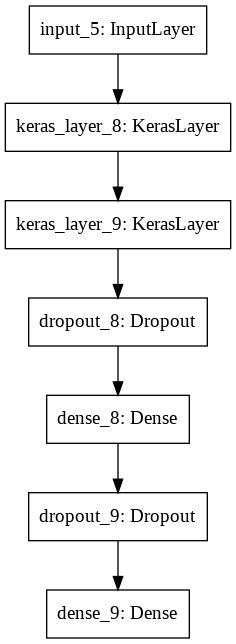

In [ ]:
#visualise the model 
plot_model(test_model)

In [ ]:
#compile parameters 

from tensorflow.keras import optimizers
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy

#fit and compile parameters 

epoch = 10
batch_size = 250
train_size = 25000
val_steps = 10

steps_per_epoch = 70
step_train = int(steps_per_epoch * epoch)
step_warmup = int(0.1* step_train)

loss_func = BinaryCrossentropy(from_logits=True)

metric = BinaryAccuracy()

# ALBERT

In [ ]:
#build the adamWeight decay optimizer

from official.nlp import optimization
from official.nlp.optimization import WarmUp, AdamWeightDecay

albert_decay = tf.keras.optimizers.schedules.PolynomialDecay(
      initial_learning_rate=3e-5,
      decay_steps=step_train,
      end_learning_rate=0)

albert_warmup = WarmUp(initial_learning_rate=3e-5,
                decay_schedule_fn=albert_decay,
                warmup_steps=step_warmup)

albert_opt = AdamWeightDecay( learning_rate= albert_warmup,
        weight_decay_rate=0.01,
        exclude_from_weight_decay=['LayerNorm', 'layer_norm', 'bias'],
        epsilon=1e-6)


In [ ]:
#build the albert model

albert_model_url = "https://tfhub.dev/tensorflow/albert_en_base/3"
albert_preprocessor_url = "http://tfhub.dev/tensorflow/albert_en_preprocess/3"

albert_model = bert_model(albert_model_url, albert_preprocessor_url)

In [ ]:
#compile and fit albert model 

albert_model.compile(loss= loss_func,
                   optimizer= albert_opt,
                   metrics= metric)

albert_history = albert_model.fit(train_data,
                          epochs= epoch,
                          validation_data = val_data,
                          shuffle = True,
                          validation_steps= val_steps,
                          steps_per_epoch = steps_per_epoch,
                          batch_size = batch_size,
                              )


Epoch 1/10


70/70 [==============================] - 443s 6s/step - loss: 22.7882 - binary_accuracy: 0.5364 - val_loss: 22.1700 - val_binary_accuracy: 0.7844
Epoch 2/10
70/70 [==============================] - 430s 6s/step - loss: 22.0063 - binary_accuracy: 0.7954 - val_loss: 21.3929 - val_binary_accuracy: 0.8219
Epoch 3/10
70/70 [==============================] - 431s 6s/step - loss: 21.3030 - binary_accuracy: 0.8133 - val_loss: 20.6860 - val_binary_accuracy: 0.8594
Epoch 4/10
70/70 [==============================] - 430s 6s/step - loss: 20.5262 - binary_accuracy: 0.8488 - val_loss: 19.9990 - val_binary_accuracy: 0.8813
Epoch 5/10
70/70 [==============================] - 431s 6s/step - loss: 19.9127 - binary_accuracy: 0.8494 - val_loss: 19.4490 - val_binary_accuracy: 0.8906
Epoch 6/10
70/70 [==============================] - 428s 6s/step - loss: 19.3592 - binary_accuracy: 0.8760 - val_loss: 18.9962 - val_binary_accuracy: 0.8813
Epoch 7/10
70/70 [==============================] - 428s 6s/step - lo

In [ ]:
#get train and test loss and accuracy 
albert_test_loss, albert_test_accuracy = albert_model.evaluate(test_data)

469/469 [==============================] - 1007s 2s/step - loss: 18.2349 - binary_accuracy: 0.8846


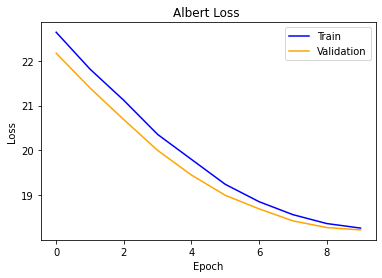

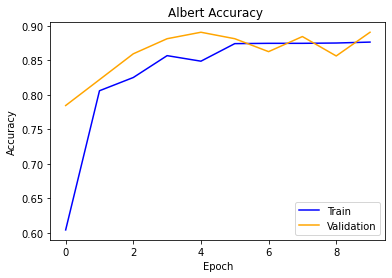

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot the results 

from matplotlib import pyplot as plt

#print(f'Albert Test Loss: {albert_test_loss}')
#print(f'Albert Test Accuracy: {albert_test_accuracy}')

#plot loss and accuracy


plt.title('Albert Loss ')
plt.plot(albert_history.history['loss'], color='blue', label='train')
plt.plot(albert_history.history['val_loss'], color='orange', label='validation')
plt.legend(['Train', 'Validation'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
plt.clf()

plt.title('Albert Accuracy ')
plt.plot(albert_history.history['binary_accuracy'], color='blue', label='train')
plt.plot(albert_history.history['val_binary_accuracy'], color='orange', label='validation')
plt.legend(['Train', 'Validation'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()
plt.clf()


# Bert Expert


https://tfhub.dev/google/experts/bert/wiki_books/sst2/2

In [ ]:
#build the adam optimizer 

expert_decay = tf.keras.optimizers.schedules.PolynomialDecay(
      initial_learning_rate=3e-5,
      decay_steps=step_train,
      end_learning_rate=0)

expert_warmup = WarmUp(initial_learning_rate=3e-5,
                decay_schedule_fn=expert_decay,
                warmup_steps=step_warmup)

expert_opt = AdamWeightDecay( learning_rate= expert_warmup,
        weight_decay_rate=0.01,
        exclude_from_weight_decay=['LayerNorm', 'layer_norm', 'bias'],
        epsilon=1e-6)


In [ ]:
#build the bert expert model

bert_expert_url = "https://tfhub.dev/google/experts/bert/wiki_books/sst2/2"
expert_preprocessor_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

bert_expert_model = bert_model(bert_expert_url, expert_preprocessor_url)

In [ ]:
# compile and fit the bert expert model 

bert_expert_model.compile(loss= loss_func,
                   optimizer= expert_opt,
                   metrics= metric)

bert_expert_history = bert_expert_model.fit(train_data,
                          epochs= epoch,
                          validation_data = val_data,
                          shuffle = True,
                          validation_steps= val_steps,
                          steps_per_epoch = steps_per_epoch,
                              )



Epoch 1/10
70/70 [==============================] - 457s 6s/step - loss: 22.5136 - binary_accuracy: 0.7162 - val_loss: 21.8656 - val_binary_accuracy: 0.8750
Epoch 2/10
70/70 [==============================] - 431s 6s/step - loss: 21.6784 - binary_accuracy: 0.8451 - val_loss: 20.8844 - val_binary_accuracy: 0.9000
Epoch 3/10
70/70 [==============================] - 422s 6s/step - loss: 20.7643 - binary_accuracy: 0.8711 - val_loss: 20.1326 - val_binary_accuracy: 0.8906
Epoch 4/10
70/70 [==============================] - 414s 6s/step - loss: 20.0311 - binary_accuracy: 0.8641 - val_loss: 19.5416 - val_binary_accuracy: 0.8813
Epoch 5/10
70/70 [==============================] - 416s 6s/step - loss: 19.4135 - binary_accuracy: 0.8644 - val_loss: 18.9591 - val_binary_accuracy: 0.9000
Epoch 6/10
70/70 [==============================] - 418s 6s/step - loss: 18.8423 - binary_accuracy: 0.8861 - val_loss: 18.5447 - val_binary_accuracy: 0.8750
Epoch 7/10
70/70 [==============================] - 419s 6

In [ ]:
# evaluate the test accuracy 

bert_expert_test_loss, bert_expert_test_accuracy = bert_expert_model.evaluate(test_data)



469/469 [==============================] - 898s 2s/step - loss: 17.7111 - binary_accuracy: 0.8951


Bert Expert Loss: 17.711069107055664
Bert Expert Accuracy: 0.8950666785240173


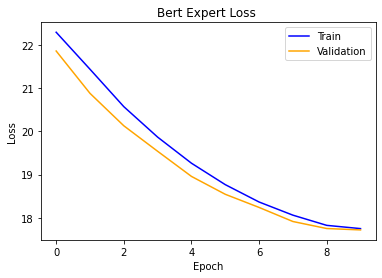

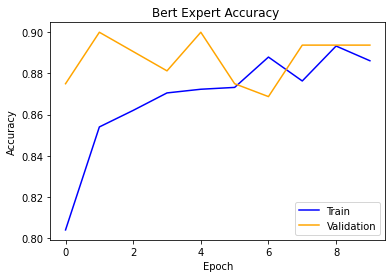

<Figure size 432x288 with 0 Axes>

In [ ]:
print(f'Bert Expert Loss: {bert_expert_test_loss}')
print(f'Bert Expert Accuracy: {bert_expert_test_accuracy}')

#plot loss and accuracy

plt.title('Bert Expert Loss ')
plt.plot(bert_expert_history.history['loss'], color='blue', label='train')
plt.plot(bert_expert_history.history['val_loss'], color='orange', label='validation')
plt.legend(['Train', 'Validation'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
plt.clf()

plt.title('Bert Expert Accuracy ')
plt.plot(bert_expert_history.history['binary_accuracy'], color='blue', label='train')
plt.plot(bert_expert_history.history['val_binary_accuracy'], color='orange', label='validation')
plt.legend(['Train', 'Validation'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()
plt.clf()


# ELECTRA


https://tfhub.dev/google/electra_base/2 

In [ ]:
!pip3 install --quiet tensorflow-text

In [ ]:
#build the adam decay optimizer
from official.nlp import optimization
from official.nlp.optimization import WarmUp, AdamWeightDecay


electra_decay = tf.keras.optimizers.schedules.PolynomialDecay(
      initial_learning_rate=3e-5,
      decay_steps=step_train,
      end_learning_rate=0)

electra_warmup = WarmUp(initial_learning_rate=3e-5,
                decay_schedule_fn=electra_decay,
                warmup_steps=step_warmup)

electra_opt = AdamWeightDecay( learning_rate= electra_warmup,
        weight_decay_rate=0.01,
        exclude_from_weight_decay=['LayerNorm', 'layer_norm', 'bias'],
        epsilon=1e-6)

In [ ]:
#build the electra model 

electra_url = "https://tfhub.dev/google/electra_base/2"
electra_preprocessor_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

electra_model = bert_model(electra_url, electra_preprocessor_url)


In [ ]:
#compile and fit the electra model 

electra_model.compile(loss= loss_func,
                   optimizer= electra_opt,
                   metrics= metric)

electra_history = electra_model.fit(train_data,
                          epochs= epoch,
                          validation_data = val_data,
                          shuffle = True,
                          validation_steps= val_steps,
                          steps_per_epoch = steps_per_epoch,
                              )



Epoch 1/10
70/70 [==============================] - 457s 6s/step - loss: 22.8177 - binary_accuracy: 0.4795 - val_loss: 22.0042 - val_binary_accuracy: 0.8531
Epoch 2/10
70/70 [==============================] - 431s 6s/step - loss: 21.8522 - binary_accuracy: 0.8282 - val_loss: 21.1650 - val_binary_accuracy: 0.8875
Epoch 3/10
70/70 [==============================] - 434s 6s/step - loss: 21.0032 - binary_accuracy: 0.8711 - val_loss: 20.4124 - val_binary_accuracy: 0.8625
Epoch 4/10
70/70 [==============================] - 428s 6s/step - loss: 20.2740 - binary_accuracy: 0.8878 - val_loss: 19.7185 - val_binary_accuracy: 0.9000
Epoch 5/10
70/70 [==============================] - 427s 6s/step - loss: 19.6482 - binary_accuracy: 0.8785 - val_loss: 19.1634 - val_binary_accuracy: 0.9125
Epoch 6/10
70/70 [==============================] - 421s 6s/step - loss: 19.1030 - binary_accuracy: 0.8733 - val_loss: 18.7395 - val_binary_accuracy: 0.8969
Epoch 7/10
70/70 [==============================] - 424s 6

In [ ]:
#evaluate the testing accuracy 
electra_loss, electra_accuracy = electra_model.evaluate(test_data)

469/469 [==============================] - 881s 2s/step - loss: 17.8791 - binary_accuracy: 0.9105


Loss: 17.879100799560547
Accuracy: 0.9105333089828491


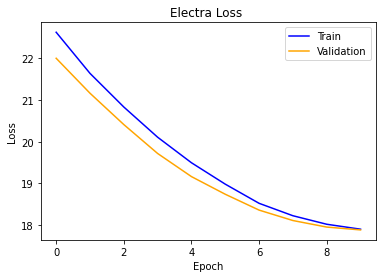

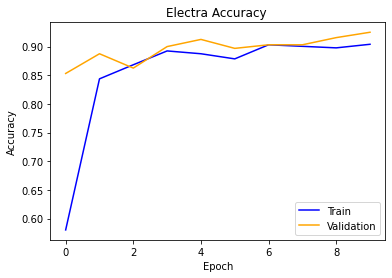

<Figure size 432x288 with 0 Axes>

In [ ]:
print(f'Loss: {electra_loss}')
print(f'Accuracy: {electra_accuracy}')

#plot loss and accuracy

plt.title('Electra Loss ')
plt.plot(electra_history.history['loss'], color='blue', label='train')
plt.plot(electra_history.history['val_loss'], color='orange', label='validation')
plt.legend(['Train', 'Validation'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
plt.clf()

plt.title('Electra Accuracy ')
plt.plot(electra_history.history['binary_accuracy'], color='blue', label='train')
plt.plot(electra_history.history['val_binary_accuracy'], color='orange', label='validation')
plt.legend(['Train', 'Validation'])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()
plt.clf()

# Final Comparison 


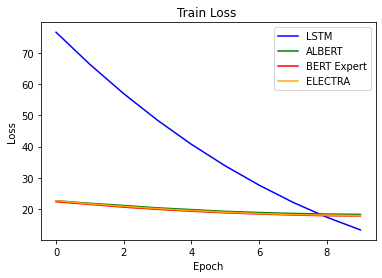

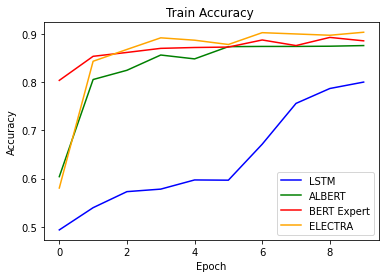

<Figure size 432x288 with 0 Axes>

In [ ]:
# plot final loss and accuracy 
plt.title('Train Loss ')
plt.plot(lstm_history.history['loss'], color='blue', label='LSTM')
plt.plot(albert_history.history['loss'], color='green', label='ALBERT')
plt.plot(bert_expert_history.history['loss'], color='red', label='BERT Expert')
plt.plot(electra_history.history['loss'], color='orange', label='ELECTRA')
plt.legend(['LSTM', 'ALBERT', 'BERT Expert', 'ELECTRA'])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
plt.clf()

plt.title('Train Accuracy ')
plt.plot(lstm_history.history['binary_accuracy'], color='blue', label='LSTM')
plt.plot(albert_history.history['binary_accuracy'], color='green', label='ALBERT')
plt.plot(bert_expert_history.history['binary_accuracy'], color='red', label='BERT Expert')
plt.plot(electra_history.history['binary_accuracy'], color='orange', label='ELECTRA')
#plt.plot(electra_history.history['val_binary_accuracy'], color='orange', label='test')
plt.legend(['LSTM', 'ALBERT', 'BERT Expert', 'ELECTRA' ])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()
plt.clf()

In [ ]:
print(f"Test Accuracy:\nLSTM: {lstm_test_acc}\nALBERT: {albert_test_accuracy}\nBERT Expert: {bert_expert_test_accuracy}\nELECTRA: {electra_accuracy}\n")
print(f"Test Loss:\nLSTM: {lstm_test_loss}\nALBERT: {albert_test_loss}\nBERT Expert: {bert_expert_test_loss}\nELECTRA: {electra_loss}")

Test Accuracy:
LSTM: 0.7946666479110718
ALBERT: 0.8845999836921692
BERT Expert: 0.8950666785240173
ELECTRA: 0.9105333089828491

Test Loss:
LSTM: 11.425619125366211
ALBERT: 18.234907150268555
BERT Expert: 17.711069107055664
ELECTRA: 17.879100799560547
